In [105]:
# https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/
# Importation des packages nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


In [106]:

# 1. Chargement et préparation des données
# Remplacez 'df_btc.csv' par le chemin de votre fichier CSV
df = pd.read_csv("cleancsv/df_sp500.csv", 
                 sep=',',
                 index_col='Date',
                 parse_dates=["Date"], 
                 dayfirst=True)

df = df.sort_values("Date")
df.tail()


,Unnamed: 0,Close,Open,High,Low
Date,,,,,
2025-02-03,4,5994.57,5969.65,6022.13,5923.93
2025-02-04,3,6037.88,5998.14,6042.48,5990.87
2025-02-05,2,6061.48,6020.45,6062.86,6007.06
2025-02-06,1,6083.57,6072.22,6084.03,6046.83
2025-02-07,0,6025.99,6083.13,6101.28,6019.96


In [107]:
#drop unnamed columns
df.drop(df.columns[df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)
df

,Close,Open,High,Low
Date,,,,
2015-02-10,2068.59,2049.38,2070.86,2048.62
2015-02-11,2068.53,2068.55,2073.48,2057.99
2015-02-12,2088.48,2069.98,2088.53,2069.98
2015-02-13,2096.99,2088.78,2097.03,2086.70
2015-02-17,2100.34,2096.47,2101.30,2089.80
...,...,...,...,...
2025-02-03,5994.57,5969.65,6022.13,5923.93
2025-02-04,6037.88,5998.14,6042.48,5990.87
2025-02-05,6061.48,6020.45,6062.86,6007.06


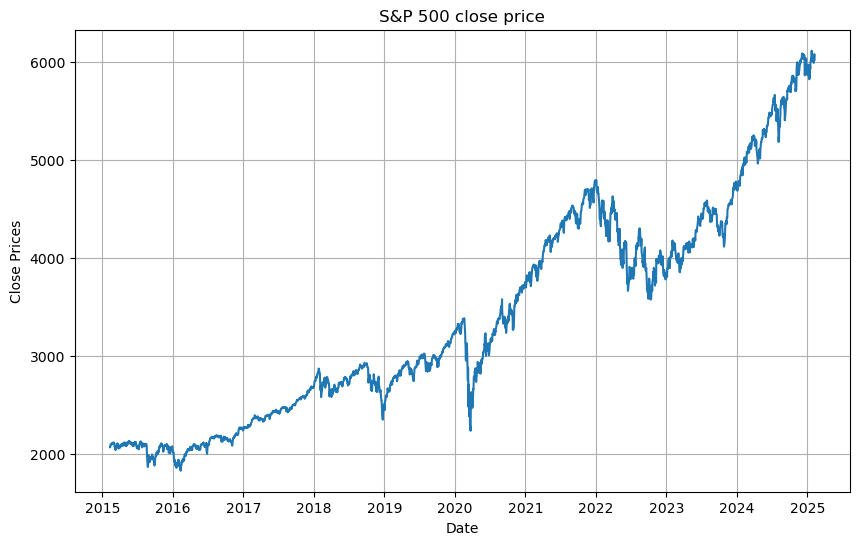

In [108]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('S&P 500 close price')
plt.show()

count    2515.000000
mean     3396.011622
std      1106.679312
min      1829.080000
25%      2450.200000
50%      3050.330000
75%      4247.015000
max      6118.710000
Name: Close, dtype: float64

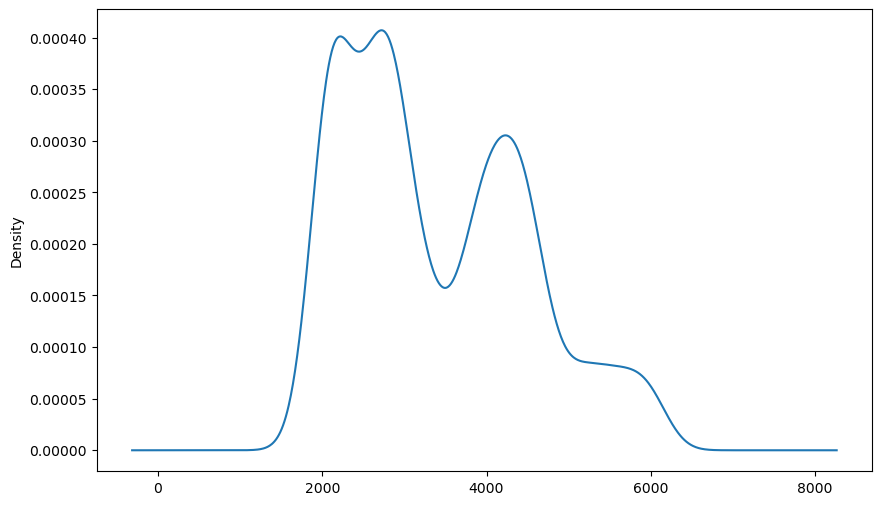

In [109]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde')
df_close.describe()

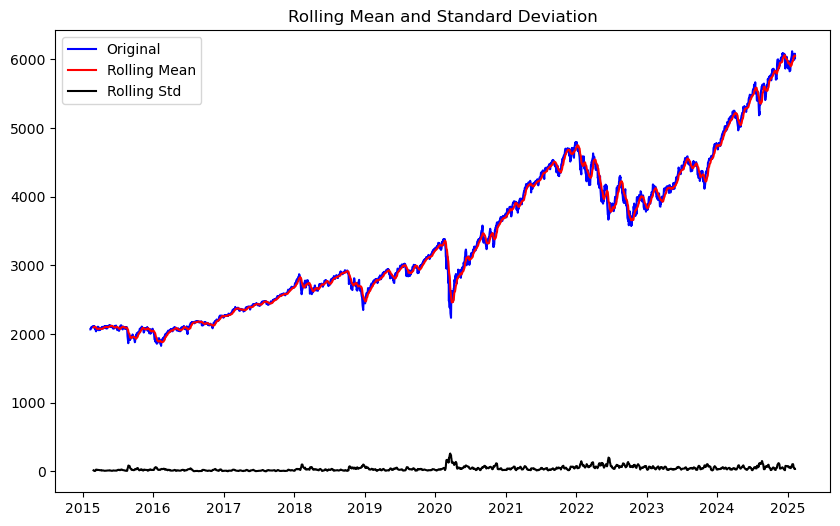

Results of dickey fuller test
Test Statistics                   0.630830
p-value                           0.988351
No. of lags used                 10.000000
Number of observations used    2504.000000
critical value (1%)              -3.432964
critical value (5%)              -2.862695
critical value (10%)             -2.567385
dtype: float64


In [110]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

La série temporelle n'est pas stationnaire car il la p-value est plus grande que 0.05. 

<Figure size 1000x600 with 0 Axes>

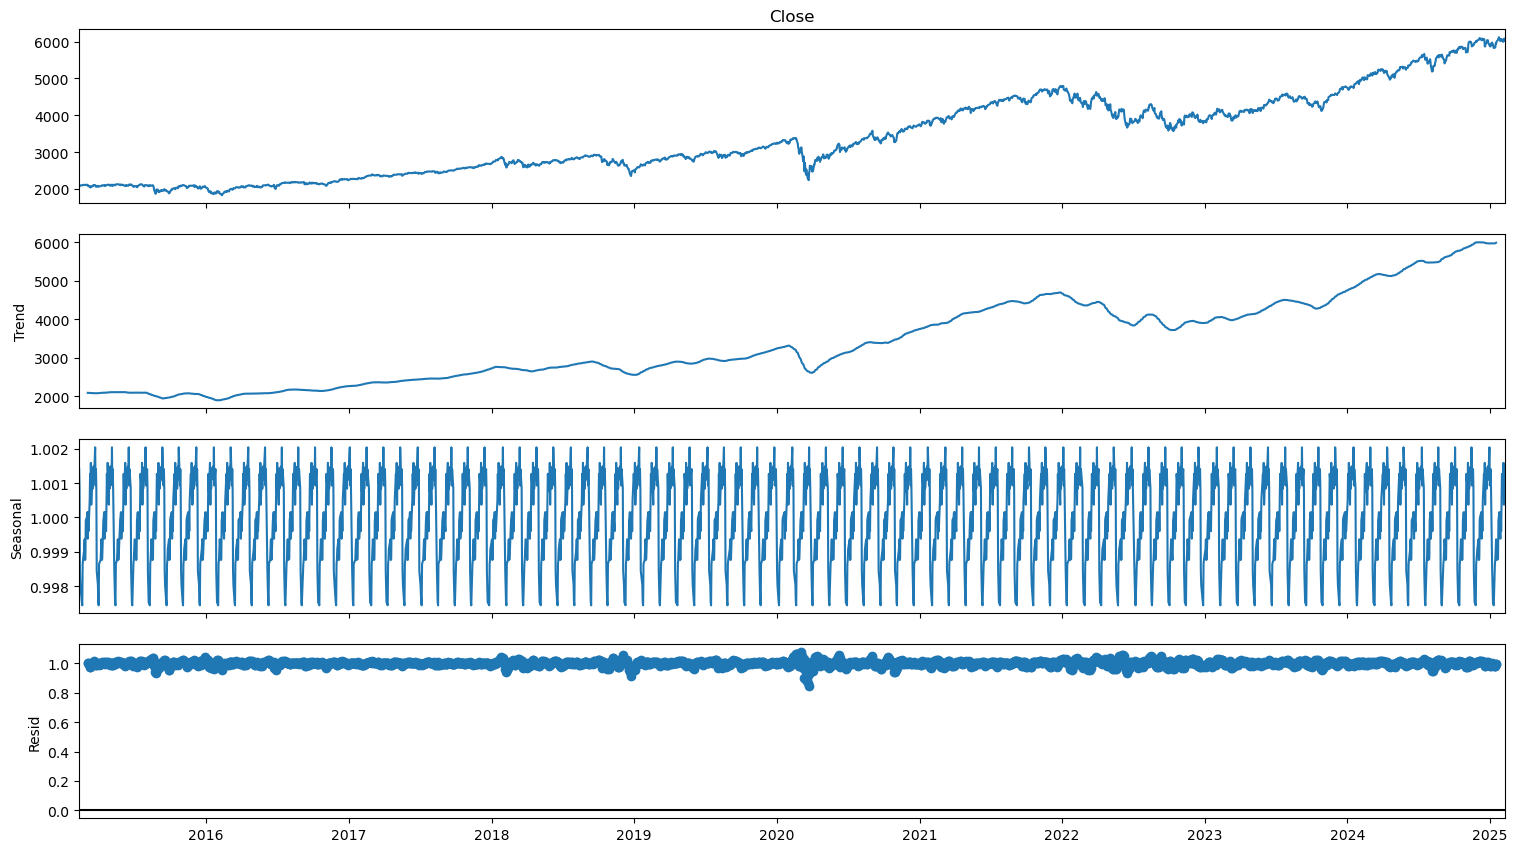

In [111]:
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

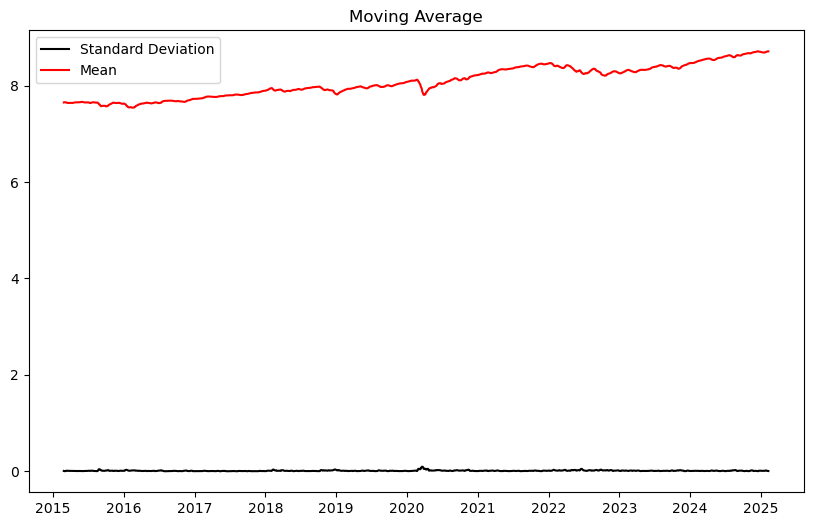

In [112]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

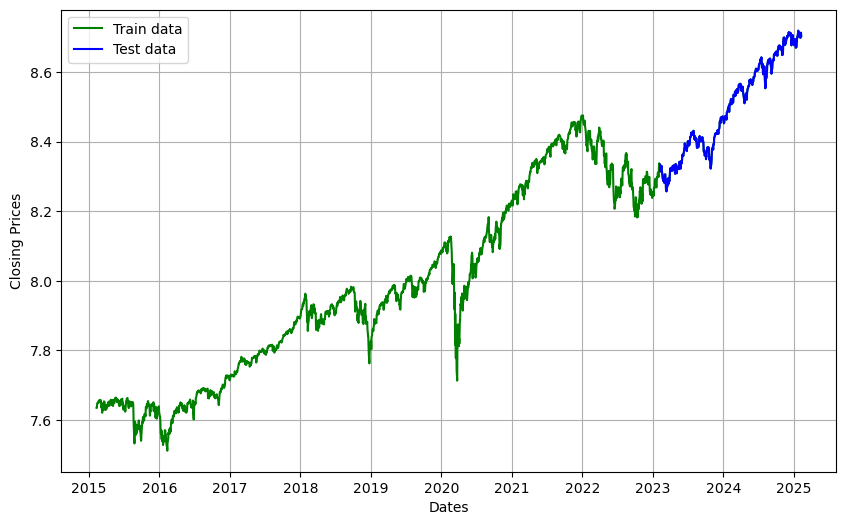

In [113]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12081.668, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12128.204, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12121.283, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12082.084, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12136.105, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12134.196, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12134.020, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12132.807, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-12132.070, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-12136.231, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-12128.039, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12134.349, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-12134.123, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-12130.967, Time=0.06 sec
 ARIM

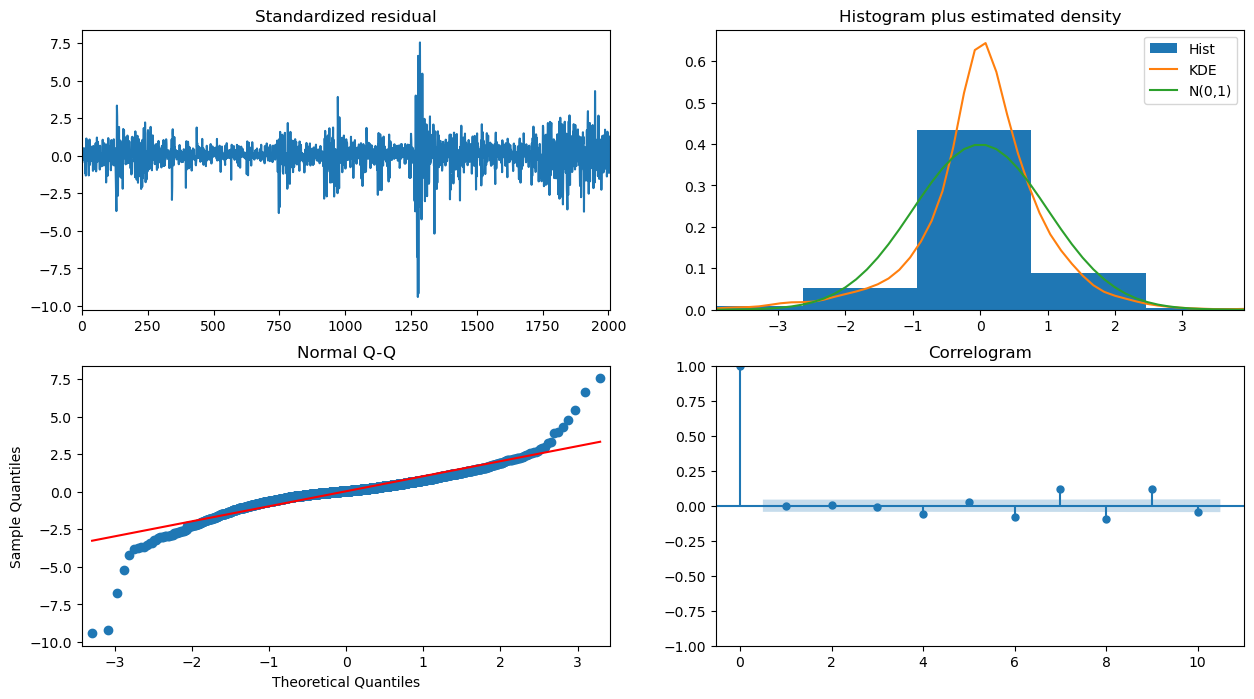

In [114]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [115]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2009
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6071.116
Date:                Tue, 11 Feb 2025   AIC                         -12136.231
Time:                        19:23:21   BIC                         -12119.417
Sample:                             0   HQIC                        -12130.059
                               - 2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1427      0.009    -15.629      0.000      -0.161      -0.125
ar.L2          0.0712      0.008      8.382      0.000       0.055       0.088
sigma2         0.0001   1.67e-06     82.883      0.0

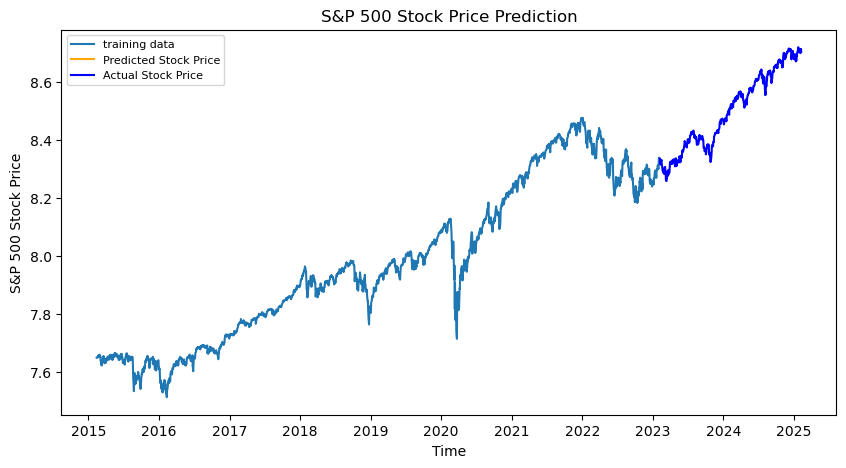

In [116]:
# Forecast
fc = fitted.forecast(321, alpha=0.05)  # 95% conf
conf = fitted.get_forecast(321).conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [117]:
# Align the lengths of test_data and fc
aligned_test_data = test_data[:len(fc)]
aligned_fc = fc[:len(aligned_test_data)]

# Convert test data to numpy array for comparison
test_np = aligned_test_data.values
forecast_np = aligned_fc.values

# Calculate performance metrics
mse = mean_squared_error(test_np, forecast_np)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_np, forecast_np)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_np, forecast_np))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_np - test_np)/np.abs(test_np))
print('MAPE: '+str(mape))

MSE: 0.01605251052495539
MAE: 0.10054836035254126
RMSE: 0.12669850245742997
MAPE: 0.011860364541038572
